In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
# package imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # set available gpus before importing torch

import json
import numpy as np
import pandas as pd

from typing import List, Tuple, Dict, Union, Optional
from pathlib import Path

# gravitational wave science
import pycbc
import pycbc.psd

In [23]:
# local imports
# from generators import *

In [24]:
# n = 100  # number of samples
# generator = WaveformGenerator(
#     spins=True,
#     inclination=True,
#     spins_aligned=False,
#     mass_ratio=False,
#     domain='RB',
# )

In [25]:
# samples = generator._sample(n, stack=True)
# samples.shape

In [26]:
# load data from event_info.json
event = 'GW150914'  # gravitational wave event label
data_dir = Path('data')  # data store
events_dir = data_dir / 'events'  # gravitational wave events
event_dir = events_dir / event  # specific event data

# Load event info
with open(event_dir / 'event_info.json', 'r') as f:
    event_info = json.load(f)
    
# load data from settings.json
waveforms_dir = Path('waveforms')
waveform_dir = waveforms_dir / event

with open(waveform_dir / 'settings.json', 'r') as f:
    settings = json.load(f)

In [27]:
# rename keys with pointers - need to unify names between saving files and attributes
# event_info['f_min_psd'] = event_info['f_min']
# event_info['duration'] = event_info['T']
# event_info['ref_time'] = event_info['t_event']

# event_info['sampling_rate'] = 2*event_info['f_max']
# event_info['delta_t'] = 1.0 / event_info['sampling_rate']
# event_info['delta_f'] = (1.0 / event_info['duration'])
# event_info['Nf'] = int(event_info['f_max'] / event_info['delta_f']) + 1

# why is this data split across two JSONs like this? data integrity??
time_duration = event_info['T']
f_max = event_info['f_max']

# event = settings['event']  # already defined to get the path in the first place
ifo_list = settings['detectors']
f_min = settings['f_min']
f_min_psd = settings['f_min_psd']
f_ref = settings['f_ref']
ref_time = settings['ref_time']

sampling_rate = 2*f_max
delta_t = 1.0 / sampling_rate
delta_f = (1.0 / time_duration)
Nf = int(f_max / delta_f) + 1


# methods used with lru_cache
sample_frequencies = np.linspace(0., f_max, Nf)
frequency_mask = sample_frequencies >= f_min

In [58]:
class PSDGenerator:
    
    def __init__(
        self,
        interferometers: List[str],
#         f_max: float,
#         f_min: float,
#         event_dir: Optional[Union[Path, str]]=None,
    ):
        ifo_list = ('H1', 'L1', 'V1')
        assert all([ifo in ifo_list for ifo in interferometers]), (
            f"Provided detector names (ifo) {interferometers} must be in {ifo_list}."
        )
        self.interferometers = interferometers
        self.detectors = {ifo: Detector(ifo) for ifo in self.interferometers}
        self.data = {ifo: {} for ifo in self.interferometers}  # psd data
        
    def get(
        self,
        ifo: str,
        delta_f: float,
    ) -> pycbc.types.FrequencySeries:
        """Return a Power Spectral Density (PSD) at a detector with given delta_f.

        PSDs are stored in a dictionary where keys are integer values corresponding
        to the width of the frequency bin. If the PSD already exists, we retrieve
        it from the dictionary store without re-computing it, otherwise we generate
        it and save it to the PSD dictionary.
        
        Note that PSDs with the same delta_f but which different f_max or f_min
        values will overwrite as this information is not used when saving to dict.

         Arguments:
            ifo {str} -- detector name
            delta_f {float} -- frequency spacing for PSD

        Returns:
            psd -- generated PSD
            
        DANIEL TO-DO: 
            Implement a more generalised structure for caching power spectral density data.
        """

        key = int(1.0/delta_f)

        if key not in self.data[ifo]:
            self.data[ifo][key] = generate_psd(ifo, self.delta_f, self.f_min, self.f_max, self.event_dir)

        return self.data[ifo][key]

In [59]:
def load_psd(
    ifo: str,
    delta_f: float,
    f_max: float,
    f_min: float,
    event_dir: Optional[Union[Path, str]]=None,
) -> pycbc.types.FrequencySeries:
    """Generate a power spectral density (PSD) as a Frequency Series given provided interferometer detector.
    
    Arguments:
        ifo: {str} -- Interferometer name according to LALSimulation (minus SimNoisePSD prefix) - prefixed with "PSD_"
        delta_f: {float} -- Frequency spacing (resolution) of the frequency series for the PSD
        f_max: {float} -- The maximum frequency for the PSD - should be half the sampling rate (see: Nyquist frequency)
        f_min_psd: {float} -- The minimum frequency for the PSD. May be different to f_min used when processing signals.
        event_dir {pathlib.Path | str} -- The directory of the event, e.g. 'data/events/GW150914'. 
            If None, this implies the PSD is not loaded and so we get from PyCBC; else we load from file.

    Returns:
        psd -- The power spectral density generated by PyCBC given our arguments.
    """
    # "The PSD length should be the same as the length of Frequency Domain (FD) waveforms,
    # which is determined from delta_f and f_max." - Green
    psd_length = int(f_max / delta_f) + 1
    
    if event_dir is None:
        # load PSD template from lalsimulation directly
        psd = pycbc.psd.from_string(
            psd_name=f'PSD_{ifo}',  # PSD name according to LALSimulation (minus SimNoisePSD prefix)
            length=psd_length,
            delta_f=delta_f,
            low_freq_cutoff=f_min,  # freq below this value are set to zero.
        )
    else:
        # load saved PSD file
        psd_filepath = event_dir / f'PSD_{ifo}.txt'
        assert psd_filepath.is_file(), f'{psd_filepath} does not exist.'
        psd = pycbc.psd.from_txt(
            filename=psd_filepath,
            length=psd_length,
            delta_f=delta_f,
            low_freq_cutoff=f_min,  # freq below this value are set to zero.
            is_asd_file=False,
        )
        
    # To avoid division by 0 when whitening, set the PSD boundary values to satisfy [f_min, f_max].
    lower = int(f_min / delta_f)
    psd[:lower] = psd[lower]
    psd[-1:] = psd[-2]

    return psd

In [60]:
from scipy.signal import tukey
from gwpy.timeseries import TimeSeries

t_event = 1126259462.391  # GPS time of coalescence

T = 8.0  # number of seconds to analyze in a segment
T_psd = 1024.0  # number of seconds of data for estimating PSD
T_buffer = 2.0  # buffer time after the event to include

# calculate a PSD T seconds before the start of the signal event
start_time = t_event + T_buffer - T - T_psd
end_time = t_event + T_buffer - T

In [61]:
start_time = 1126051217
end_time = 
data = TimeSeries.fetch_open_data('H1', start_time, end_time, cache=True)
https://www.gw-openscience.org/archive/md5/O1/strain-hdf.txt

In [62]:
def estimate_psd(
    ifo: str,
    start_time: float,
    end_time: float,
    window: float=8,
    cache: bool=True,
) -> pycbc.types.FrequencySeries:
    """Estimates the power spectral density using the welch method with PyCBC with
    data sourced from gwpy.TimeSeries.fetch_open_data.
    
    Args:
        ifo: The detector name
        start_time: The start time of the observed timeseries to generate the PSD from.
        end_time: The end time of the observed timeseries to generate the PSD from.
        window: The window time duration to bin the observed timeseries.
        
        cache: Whether to cache the data ccording to gwpy.Timeseries.fetch_open_data.
    
    Returns:
        A pycbc.FrequencySeries describing the PSD given the detector data.
    
    """
    # get data from gwpy and convert to pycbc timeseries
    timeseries = TimeSeries.fetch_open_data(ifo, start_time, end_time, cache=cache)
    
    # tukey window as used in LALInference https://arxiv.org/abs/1409.7215
    roll_off = 0.4  # 0.4sec
    alpha = 2 * roll_off / window
    sampling_frequency = len(data)/(end_time - start_time)
    nbins = int(window * sampling_frequency)  # Number of points in output window
    window = tukey(nbins, alpha)
    
    return pycbc.psd.estimate.welch(
        timeseries=timeseries.to_pycbc(),
        seg_len=nbins,
        seg_stride=nbins,
        window=tukey(nbins, alpha),
        avg_method='median'
    )

In [67]:
psd_generator = PSDGenerator(detectors=('H1', 'L1'))
psd_data = {
    ifo: estimate_psd(ifo, start_time, end_time, window=T).data
    for ifo in psd_generator.detectors
}

In [77]:
f_max

1024.0

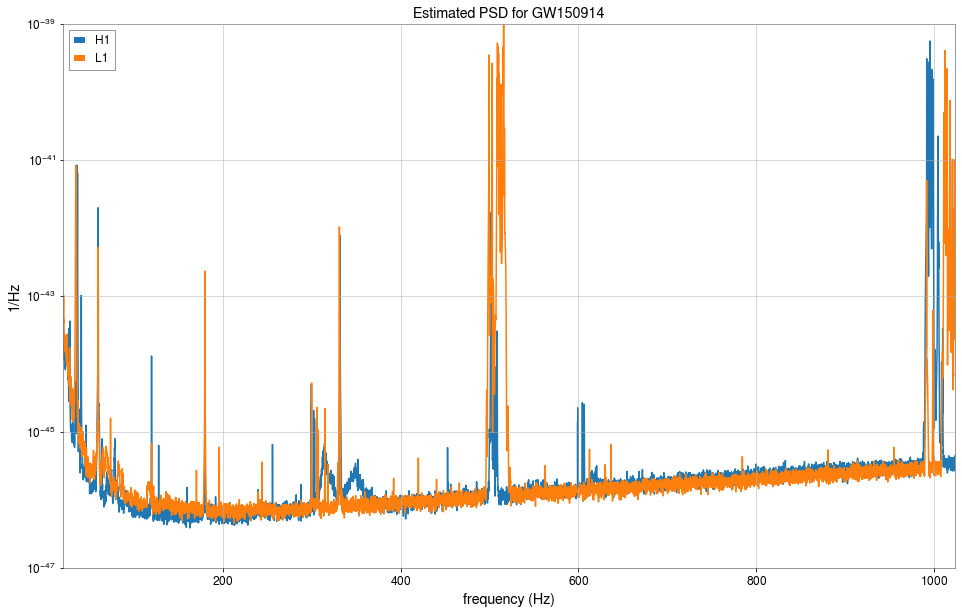

In [79]:
psd_df = pd.DataFrame(data=psd_data, index=psd.sample_frequencies)
psd_df.plot(
    figsize=(16,10),
    logy=True,
    xlabel='frequency (Hz)',
    ylabel='1/Hz',
    title=f'Estimated PSD for {event}',
    xlim=(f_min, f_max),
    ylim=(1e-47, 1e-39),
);

In [87]:
from gwpy.segments import DataQualityFlag
h1segs = DataQualityFlag.fetch_open_data('H1_DATA', 'Sep 12 2015', 'Jan 19 2016')

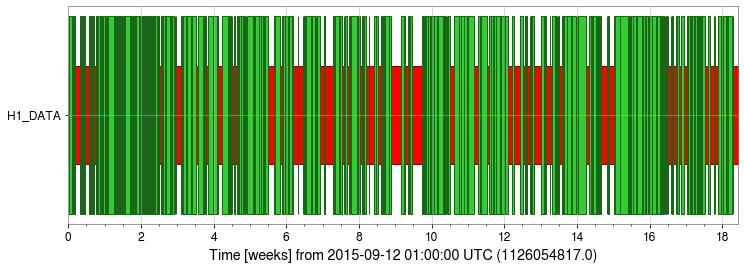

In [90]:
plot = h1segs.plot(color='gwpy:ligo-hanford')
plot.show()

In [97]:
# h1 = TimeSeries.fetch_open_data('H1', 'Sep 12 2015','Oct 12 2015', cache=True)
# l1 = TimeSeries.fetch_open_data('L1', 'Sep 12 2015', 'Oct 12 2015', cache=True)

ValueError: Cannot find a LOSC dataset for H1 covering [1126051217, 1128643217)

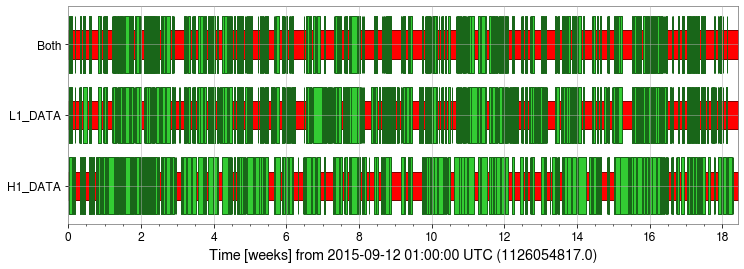

In [95]:
h1quality = DataQualityFlag.fetch_open_data('H1_DATA', 'Sep 12 2015','Jan 19 2016')
l1quality = DataQualityFlag.fetch_open_data('L1_DATA', 'Sep 12 2015', 'Jan 19 2016')
bothon = h1quality & l1quality
plot = h1quality.plot()
ax = plot.gca()
ax.plot(l1quality)
ax.plot(bothon, label='Both')
plot.show()

In [118]:
(h1quality.active[0][1] - h1quality.active[0][0])/1024

40.36328125

In [119]:
h1quality.active[0][0]

1126073529

In [126]:
import time
s = time.time()
data = TimeSeries.fetch_open_data(
    'H1',
    h1quality.active[0][0],
    h1quality.active[0][1],
    cache=True
)
e = time.time()
duration = round(e-s, 4)
print(f'fetching open data took {duration}s')

fetching open data took 6.9314s


In [125]:
data

<TimeSeries([ 1.01690442e-19,  1.33631628e-19,  1.03942613e-19,
             ..., -7.33031947e-15, -7.31149603e-15,
             -7.29263813e-15]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12607353e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

In [104]:
import inspect
inspect.getmembers(h1quality.active)

[('__abs__',
  <method-wrapper '__abs__' of SegmentList object at 0x7fce6f4a7bd0>),
 ('__add__',
  <method-wrapper '__add__' of SegmentList object at 0x7fce6f4a7bd0>),
 ('__and__',
  <method-wrapper '__and__' of SegmentList object at 0x7fce6f4a7bd0>),
 ('__class__', gwpy.segments.segments.SegmentList),
 ('__contains__',
  <method-wrapper '__contains__' of SegmentList object at 0x7fce6f4a7bd0>),
 ('__delattr__',
  <method-wrapper '__delattr__' of SegmentList object at 0x7fce6f4a7bd0>),
 ('__delitem__',
  <method-wrapper '__delitem__' of SegmentList object at 0x7fce6f4a7bd0>),
 ('__dict__', {}),
 ('__dir__', <function SegmentList.__dir__()>),
 ('__doc__',
  'A `list` of `Segments <Segment>`\n\n    The `SegmentList` provides additional methods that assist in the\n    manipulation of lists of `Segments <Segment>`. In particular,\n    arithmetic operations such as union and intersection are provided.\n    Unlike the `Segment`, the `SegmentList` is closed under all supported\n    arithmetic 